## Try peterY's notebook for transients ##

**2016-01-09** - push towards a figure of merit. In this case, fraction of galactic supernovae that might be discovered. Use existing diagnostic metrics for this case.

We use a "typical" Type 1a lightcurve (e.g. Firth et al. 2015 MNRAS 446, 3895): rising $\alpha \approx 2.4$, time to peak $18.98 \pm 0.54 \approx 19.0$ days. Decay time $\approx 100$ days.

**2016-04-10 WIC update:** The notebooks in the github repository "lsstScratchWIC" will soon all look for previously-run metrics in a subdirectory of the repository: [topDir]/data/metricOutputs . There is now a (commented) step below to run this metric so that the outputs go to that location (and will thus be easily read by e.g. FigureOfMerit_4p3_Galactic_Supernova.ipynb).

In [1]:
%matplotlib inline

In [2]:
import time

In [3]:
# Follow the steps of PeterY's notebook
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

In [4]:
# LSST stuff
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db

/Users/clarkson/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [ ]:
import os

### Send outputs to the directory we want ###

In [ ]:
# uncomment to follow the convention of the repository. 
# Note that then the outputs will be submittable to the repository.

#topDir = '/Users/clarkson/Progs/Projects/lsstScratchWIC'
#os.chdir('%s/data/metricOutputs' % (topDir))

### Set parameters for the transient ###

In [5]:
# Take a look at a synthetic lightcurve set. A SN in the MW could get very bright indeed...

# The way peterY's transient seems to work, the lightcurve is constructed outward
# from the peak. So make the peaks very bright...
peaks = {'uPeak':11, 'gPeak':9, 'rPeak':8, 'iPeak':7, 'zPeak':6,'yPeak':6}
colors = ['b','g','r','purple','y','magenta','k']
filterNames = ['u','g','r','i','z','y']



In [6]:
# Timing parameters of the outbursts
riseSlope = -2.4
# riseSlope = -0.5  # Changing riseSlope changes the faintest mag this reaches b4 peak.
#declineSlope = 0.05  # Make this steeper for prompt emission (and to fit more tests in)
declineSlope = 0.05  # following Ofek et al. 2013
transDuration = 80.
peakTime = 20.

### Taking a look at the transient lightcurve ###


In [7]:
transMetric = metrics.TransientMetric(riseSlope=riseSlope, declineSlope=declineSlope, \
                                      transDuration=transDuration, peakTime=peakTime, \
                                      **peaks)

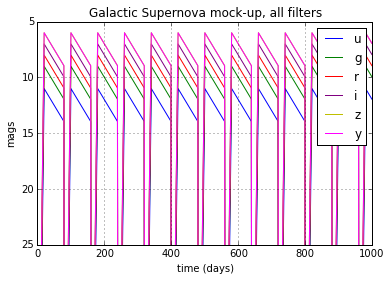

In [8]:
# try plotting:
times = np.arange(1000.)
for filterName, color in zip(filterNames,colors):
    filters = np.array([filterName]*times.size)
    lc = transMetric.lightCurve(times % transDuration,filters)
    plt.plot(times,lc, color, label=filterName)
plt.xlabel('time (days)')
plt.ylabel('mags')
plt.ylim([25,5])
#plt.xlim(0, transDuration)
plt.legend()
plt.title('Galactic Supernova mock-up, all filters')
plt.grid()

## Set up metric list we want, r-only to assess cadence only. ##

In [9]:
slicer = slicers.HealpixSlicer(nside=64)
summaryMetrics = [metrics.MedianMetric()]

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [10]:
nPhaseCheck=20
nPrePeak=3
metricList = []
metricAlert = metrics.TransientMetric(riseSlope=riseSlope, declineSlope=declineSlope, \
                                      transDuration=transDuration, peakTime=peakTime, \
                                      metricName='Alert, sawtooth', \
                                     nPhaseCheck=nPhaseCheck, **peaks)

metricRise = metrics.TransientMetric(riseSlope=riseSlope, declineSlope=declineSlope, \
                                      transDuration=transDuration, peakTime=peakTime, \
                                      metricName='%i detections on rise' % (nPrePeak), \
                                    nPrePeak=nPrePeak, \
                                    nPhaseCheck=nPhaseCheck, **peaks)

metricList = [metricAlert, metricRise]
#metricList=[metricRise]

## Setup for ops2_1092 ##

In [11]:
runName1092 = 'ops2_1092'
#sqlconstraint = 'filter = "r"'
sqlconstraint = ''
bDict1092={}
for i,metric in enumerate(metricList):
    bDict1092[i] = metricBundles.MetricBundle(metric, slicer, sqlconstraint, 
                                          runName=runName1092, summaryMetrics=summaryMetrics)

In [12]:
opsdb1092 = db.OpsimDatabase(runName1092 + '_sqlite.db')
outDir1092 = 'Transients1092Like2010mc'
resultsDb1092 = db.ResultsDb(outDir=outDir1092)

## Setup for enigma_1189 ##

In [13]:
runName1189 = 'enigma_1189'
#sqlconstraint = 'filter = "r"'
bDict1189={}
for i,metric in enumerate(metricList):
    bDict1189[i] = metricBundles.MetricBundle(metric, slicer, sqlconstraint, 
                                          runName=runName1189, summaryMetrics=summaryMetrics)

In [14]:
opsdb1189 = db.OpsimDatabase(runName1189 + '_sqlite.db')
outDir1189 = 'Transients1189Like2010mc'
resultsDb1189 = db.ResultsDb(outDir=outDir1189)

## Run both!! ##

Querying database with no constraint.
Found 2469027 visits
Running:  [0, 1]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with  sqlconstraint now.
monopole: 0.789496  dipole: lon: 118.433, lat: -73.4636, amp: 0.103808
monopole: 0.264176  dipole: lon: 47.6662, lat: -4.23582, amp: 0.013112
Plotting complete.
Time spent on 1092: 1.027e+03 seconds


Optimal bin calculation tried to make 202 bins, returning 200


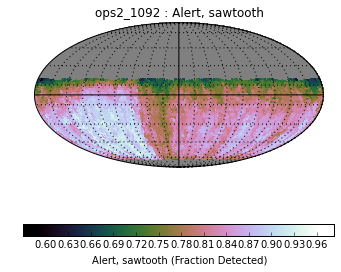

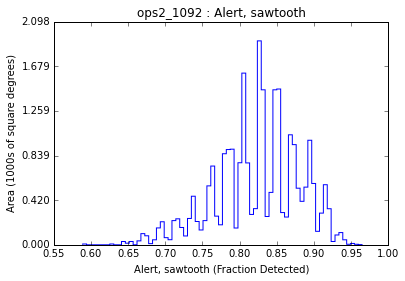

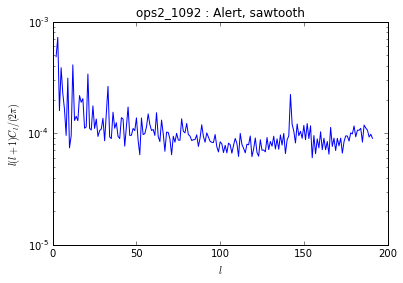

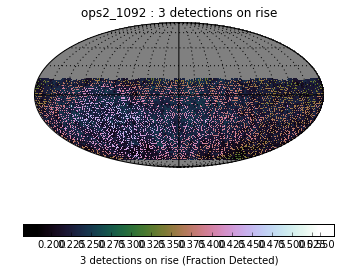

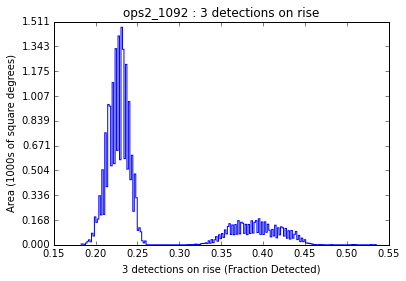

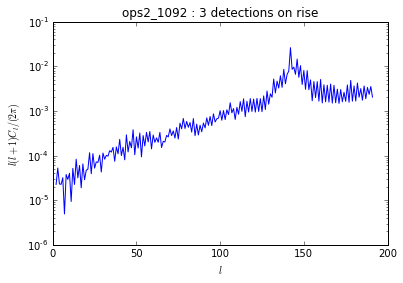

In [15]:
tStart = time.time()
bgroup1092 = metricBundles.MetricBundleGroup(bDict1092, opsdb1092, outDir=outDir1092, \
                                             resultsDb=resultsDb1092)
bgroup1092.runAll()
bgroup1092.plotAll(closefigs=False)
tPost1092 = time.time()
print "Time spent on 1092: %.3e seconds" % (tPost1092 - tStart)

Querying database with no constraint.
Found 2469307 visits
Running:  [0, 1]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with  sqlconstraint now.
monopole: 0.580118  dipole: lon: 89.2482, lat: -67.0982, amp: 0.143352
monopole: 0.216081  dipole: lon: 94.6008, lat: -69.3044, amp: 0.0569953
Plotting complete.
Time spent on 1189: 1.367e+04 seconds


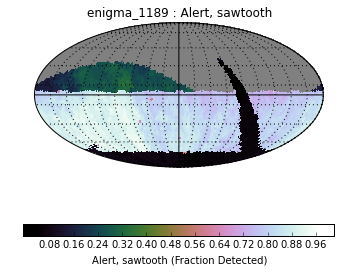

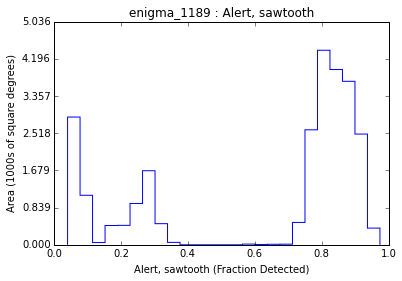

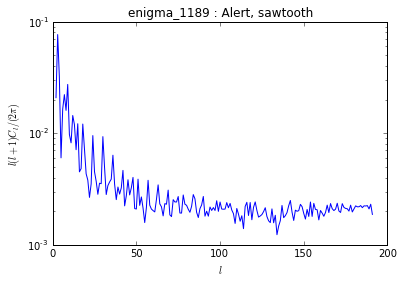

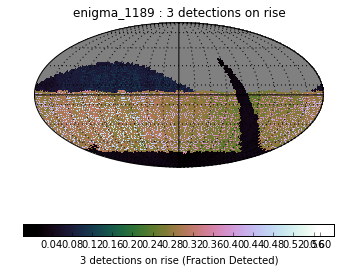

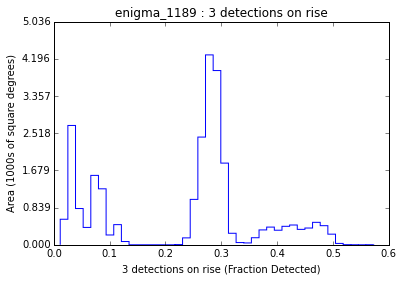

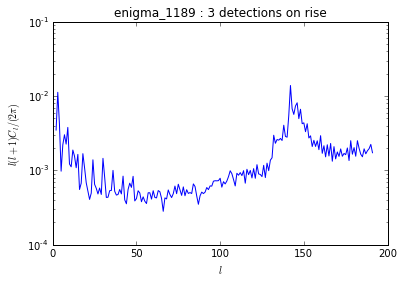

In [16]:
tPost1092 = time.time()
bgroup1189 = metricBundles.MetricBundleGroup(bDict1189, opsdb1189, outDir=outDir1189, \
                                             resultsDb=resultsDb1189)
bgroup1189.runAll()
tPost1189 = time.time()
bgroup1189.plotAll(closefigs=False)
print "Time spent on 1189: %.3e seconds" % (tPost1189 - tPost1092)

